## Install dependencies
### Pull llama3.2 (3B) model using ollama

In [ ]:
!ollama pull llama3.2

### Install Dependencies

In [121]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model Configuration

In [1]:
### Initialize the Ollama model
from langchain_ollama import ChatOllama

# LLM model name
MODEL = "llama3.2"
# Model Creativity
TEMPERATURE = 0
# Model for embeddings
EMBEDDINGS_MODEL = "nomic-embed-text-v1.5"

llm = ChatOllama(model=MODEL, temperature=TEMPERATURE)
llm_json = ChatOllama(model=MODEL, temperature=TEMPERATURE, format="json")

### Data Preparation and Knowledge Base

In [137]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Qdrant
from langchain_nomic.embeddings import NomicEmbeddings
import re

def load_doc_url(urls, chunk_size=500, chunk_overlap=100):
    """
    Get and clean content from URLs. Split the content into chunks.

    Args:
        urls (list[str]): List of URLs
        chunk_size (int): Size of the chunks
        chunk_overlap (int): Overlap between chunks
    
    Returns:
        (list[Document]): List of splitted documents
    """
    # Load documents
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    # Remove unnecessary spaces from the page content
    for doc in docs_list:
        doc.page_content = re.sub(r"(\n|\t| )+", r"\1", doc.page_content)

    # Split documents
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return text_splitter.split_documents(docs_list)

urls = [
    "https://metanoia-it.de/en/",
    "https://metanoia-it.de/en/startups/",
    "https://metanoia-it.de/en/about-us/",
    "https://synoptek.com/industry-solutions/it-services-start-ups/",
    "https://youteam.io/blog/do-i-need-a-startup-consultancy/",
    "https://aimconsulting.com/insights/it-consulting-services-meaning-expertise-business/",
]

doc_splits = load_doc_url(urls)

# Add to vectorDB
embeddings = NomicEmbeddings(model=EMBEDDINGS_MODEL, inference_mode="local", device="nvidia")
vectorstore = Qdrant.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    #path="./KnowledgeBase",
    location=":memory:",
    collection_name="KB"
)

# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [138]:
retriever.invoke("metanoia")

[Document(metadata={'source': 'https://metanoia-it.de/en/', 'title': 'Homepage - Metanoia IT Solutions GmbH IT-Dienstleister', 'description': 'Metanoia IT Solutions ein dynamischer IT-Dienstleister, das sich auf Dienstleistungen im Bereich der Informationstechnologie spezialisiert.', 'language': 'en-US', '_id': '9d5e1b19f2d34f4abe0fc31a94047d04', '_collection_name': 'KB'}, page_content='Homepage - Metanoia IT Solutions GmbH IT-Dienstleister\nHome\nServices\nFor start-ups\nAbout us\nCustomers\nAuf Deutsch wechseln ðŸ‡©ðŸ‡ª\n\r\tContact us\n\r\tContact us\nCode, Cloud und AI-Driven Tech Your vision, our code. With cloud power, AI magic and experience, we bring a breath of fresh air to your digital projects. Let’s code the future!\nGet to know us\nOur solutions for your company\nMetanoia IT Solutions GmbH supports young ideas and companies in their IT.We have specialised in the digitalisation of young, online-based business models.StartupsInfluencersDigital agenciesE-Commerce Brands\nArra

In [8]:
# Print the updated page content
print(doc_splits[0].page_content)

Homepage - Metanoia IT Solutions GmbH IT-Dienstleister
Home
Services
For start-ups
About us
Customers
Auf Deutsch wechseln ðŸ‡©ðŸ‡ª
	Contact us
	Contact us
Code, Cloud und AI-Driven Tech Your vision, our code. With cloud power, AI magic and experience, we bring a breath of fresh air to your digital projects. Let’s code the future!
Get to know us
Our solutions for your company
Metanoia IT Solutions GmbH supports young ideas and companies in their IT.We have specialised in the digitalisation of young, online-based business models.StartupsInfluencersDigital agenciesE-Commerce Brands
Arrange a free initial consultation	Software development	Read more	IT infrastructure & security	Mehr erfahren	Digitalisation & AI agents	Read more	E-Commerce	Read more
How does the collaboration work?
Get to know us and our expertise in a video call.	1	Appointment request
Choose a suitable date in our Calender and describe your request in 2-3 sentences.	2	Virtual initial consultation
You will get to know one o

### Model Instructions and Testing

In [61]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to Metanoia and IT consulting.

Use the vectorstore for questions on these topics. Else, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""


In [62]:
# Test router
test_web_search = llm_json.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"
        )
    ]
)
test_web_search_2 = llm_json.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What does Metanoia do?")]
)
test_vector_store = llm_json.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Who were customers of Metanoia?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'websearch'} {'datasource': 'vectorstore'} {'datasource': 'vectorstore'}


In [ ]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""


In [12]:
# Test
question = "Who were customers of Metanoia?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'no'}

In [13]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [14]:
# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

According to the provided context, customers of Metanoia IT Solutions GmbH include startups such as Lucoyo, PRUEFSTER, and WasteAnt, as well as digital agencies and e-commerce brands. These customers have successfully implemented Metanoia's solutions for their digital projects. The company also mentions that they have interviewed customers and asked them to share their personal "Metanoia story" on their website.


In [15]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""


In [16]:
# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The STUDENT ANSWER is grounded in the FACTS because it accurately identifies specific customers of Metanoia IT Solutions GmbH (Lucoyo, PRUEFSTER, and WasteAnt) and mentions that these customers have successfully implemented Metania's solutions. Additionally, the STUDENT ANSWER correctly references the company's mission to support startups and their digital projects, as well as the fact that they have interviewed customers to share their personal 'Metanoia story'. The only potential issue is that the STUDENT ANSWER does not explicitly mention the company's services or solutions, but this information is not required to be included in order for the answer to be considered grounded in the FACTS."}

In [17]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""


In [18]:
# Test
answer = generation.content

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer
)
result = llm_json.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer helps to answer the question by providing specific examples of customers who have used Metanoia's solutions (Lucoyo, PRUEFSTER, and WasteAnt) and mentioning that digital agencies and e-commerce brands are also customers. Additionally, the student mentions that these customers have shared their personal 'Metania story' on the company's website, which provides further evidence of the company's customer base. The answer contains extra information about how Metanoia interacts with its customers (through interviews), but it still meets all the criteria specified in the question."}

## Workflow

In [19]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

### Nodes

In [ ]:
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

In [21]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}

In [125]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    web_search = state["web_search"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            if web_search:
                web_search = "Yes"
            continue
    if filtered_docs or not web_search:
        web_search = "No"
    return {"documents": filtered_docs, "web_search": web_search}

#### Web Scraping

In [77]:
from bs4 import BeautifulSoup
import requests

def search_url(query, num_results=3):
    """
    Get search results from Google

    Args:
        query (str): The search query

    Returns:
        urls (list): List of URLs from the search
    """

    question = query
    search_url = 'https://www.google.com/search'

    headers = {
        'Accept' : '*/*',
        'Accept-Language': 'en-US,en;q=0.5',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82',
    }
    parameters = {'q': question}

    content = requests.get(search_url, headers = headers, params = parameters).text
    soup = BeautifulSoup(content, 'html.parser')

    search = soup.find(id = 'search')
    links = search.find_all('a')
    
    return [link.get('href') for link in links if link.get('href', '').startswith('https://')][:num_results]

search_url('What are the types of agent memory?')

['https://www.newsletter.swirlai.com/p/memory-in-agent-systems#:~:text=Memory%20component%20of%20an%20Agent.&text=Generally%2C%20we%20tend%20to%20use,further%20split%20into%20multiple%20types.',
 'https://blog.langchain.dev/memory-for-agents/',
 'https://translate.google.com/translate?hl=de&sl=en&u=https://blog.langchain.dev/memory-for-agents/&prev=search&pto=aue']

In [48]:
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = load_doc_url(search_url(question))
    for doc in docs:
        documents.append(doc)
    return {"documents": documents}

### Edges

In [25]:
### Edges

def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [ ]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [27]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

## Control Flow

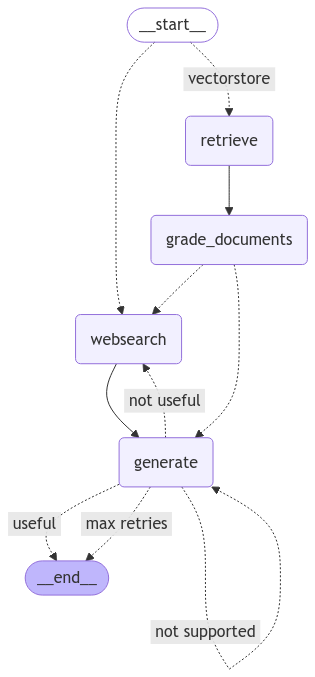

In [144]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Chat History and Query Functions

In [175]:
from langchain.memory import ConversationBufferMemory

# Initialize memory for tracking chat history
chat_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

def update_chat_history(user_message, bot_message):
    """
    Function to update the chat history after each query
    
    Args:
        user_message (str): The user question
        bot_message (str): The bot response
    """
    # Save context to memory after each question/response
    chat_memory.save_context({"input": user_message}, {"output": bot_message})
    # Optionally, print the updated chat history for debugging
    #print(f"Updated Chat History:\n{chat_memory.load_memory_variables({})['chat_history']}")

def get_chat_history(chat_memory):
    """
    Function to get the chat history
    
    Returns:
        list: The chat history
    """
    return chat_memory.load_memory_variables({})["chat_history"]

def print_chat_history(chat_memory):
    """
    Function to print the chat history
    
    Args:
        chat_memory (ConversationBufferMemory): The chat memory
    """
    chat_history = get_chat_history(chat_memory)
    for entry in chat_history:
        print(f"{entry.type}: {entry.content}\n")

def ask_question(question, max_retries=1, web_search=True):
    """
    Ask a question and get an answer
    
    Args:
        question (str): The user question
        max_retries (int): Maximum number of retries for answer generation
        web_search (bool): True to enable web search even if there are some relevant documents, False to disable
    
    Returns:
        str: Answer to the question
    """
    inputs = {"question": question, "max_retries": max_retries, "web_search": web_search}
    events = []

    # Iterate through the graph, streaming events
    for event in graph.stream(inputs, stream_mode="values"):
        events.append(event)

    # Get the final answer
    bot_message = events[-1]["generation"].content
    update_chat_history(question, bot_message)
    
    # Return the final generated answer
    return bot_message

In [176]:
ask_question("Tell me about metanoia IT and it's customers", web_search=True)
ask_question("Recommend me some german dishes", web_search=True)

print_chat_history(chat_memory)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
human: Tell me about metanoia IT and it's customers

ai: Metanoia IT Solutions GmbH is a German IT company that specializes in providing software development, cloud, and AI-driven solutions for startups, digital agencies, e-commerce brands, and other clients. Their customers include well-known companies such as Lucoyo, P

In [177]:
ask_question("Recommend me some Thai dishes", web_search=False)

print_chat_history(chat_memory)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
human: Tell me about metanoia IT and it's customers

ai: Metanoia IT Solutions GmbH is a German IT company that specializes in providing software development, cloud, and AI-driven solutions for startups, digital agencies, e-commerce brands, and other clients. Their customers include well-known companies such as Lucoyo, PRUEFSTER, and WasteAnt, who have praised their expertise in web development, infrastructure, security, and AI optimization. By partnering with Metanoia IT, startups can benefit from efficient solutions, expert support, and cost-effective services to drive growth and success.

human: Recommend me some german dishes

ai: Here is a possible answer:

Try making Apfelstrudel, Schwarzwälder Kirschtorte, or Schnitzel, which are all p

In [178]:
ask_question("Who is the founder of metanoia IT", web_search=False)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---


'I don\'t have any information about a company called "metanoia IT" or its founder in the provided context. The context seems to be incomplete, and I couldn\'t find any relevant details about metanoia IT. Therefore, I cannot provide an accurate answer to your question.'